# Lab - 52087 Neural Fields

This lab explores **neural fields** (implicit neural representations) for 2D image reconstruction. We treat an image as a continuous function:
- input: pixel coordinates (x,y) (normalized to [-1,1])
- output: RGB color in [0,1]

The lab is organized into three stages.

1) Baseline MLP  
Train a standard MLP that maps 2D coordinates to RGB. You should observe the classic *low-frequency bias* (blurry reconstructions).

2) Positional Encoding (PE)  
Encode coordinates with higher-frequency features before feeding them to an MLP. We include two options commonly used in neural fields see 6.1 in [paper](https://arxiv.org/pdf/2006.10739):
- sinusoidal Fourier features (deterministic frequency bands) 
- Gaussian random Fourier features (random frequencies sampled from a Gaussian)

3) SIREN  
Replace ReLU with sine activations and use SIREN-style initialization (periodic activation as an inductive bias) to represent higher frequencies without explicit input encoding.

During training we track basic metrics (loss, PSNR; optional SSIM) and plot training dynamics. In the student version, you can remove the plotting/metrics blocks and ask students to implement them.


In [1]:

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda



## Data Preparation

To train a neural field on an image, we need a dataset of coordinate–color pairs. Each pixel location is treated as a coordinate \((x,y)\) in a continuous domain (normalized to \([-1,1]\)), and the corresponding RGB value is the target. We provide utility functions to load an image from disk or generate a synthetic pattern and then sample a dense grid of coordinates and colors.

If you want to train on your own image, place the image file in the same directory as this notebook and set `image_path` accordingly. The default synthetic pattern demonstrates the method without requiring external files.


In [3]:

from typing import Tuple

def load_image(path: str, resize: Tuple[int, int]=(128, 128)) -> np.ndarray:
    # Load an image from path, resize to the desired resolution and return a normalized
    # numpy array of shape (H, W, 3) with values in [0,1].
    img = Image.open(path).convert('RGB')
    img = img.resize(resize)
    img_np = np.asarray(img, dtype=np.float32) / 255.0
    return img_np


def generate_synthetic_image(resolution: int = 128) -> np.ndarray:
    # Generate a synthetic RGB image using sinusoidal patterns.  This avoids external
    # dependencies and provides a known ground truth with high‑frequency content.
    x = np.linspace(0, 1, resolution)
    y = np.linspace(0, 1, resolution)
    xv, yv = np.meshgrid(x, y)
    img = np.zeros((resolution, resolution, 3), dtype=np.float32)
    # Red channel: high‑frequency checkerboard pattern
    img[..., 0] = (np.sin(2 * np.pi * 6 * xv) * np.sin(2 * np.pi * 6 * yv) + 1) / 2
    # Green channel: low‑frequency radial gradient
    r = np.sqrt((xv - 0.5) ** 2 + (yv - 0.5) ** 2)
    img[..., 1] = 1 - r / np.max(r)
    # Blue channel: diagonal stripes
    img[..., 2] = (np.sin(2 * np.pi * 4 * (xv + yv)) + 1) / 2
    return img


def prepare_dataset(img: np.ndarray) -> Tuple[torch.Tensor, torch.Tensor]:
    # Given an image array of shape (H, W, 3), return tensors:
    #  coords: (N, 2) containing (x,y) in [-1,1]
    #  colors: (N, 3) containing RGB in [0,1]
    h, w, c = img.shape
    ys = np.linspace(-1.0, 1.0, h)
    xs = np.linspace(-1.0, 1.0, w)
    xv, yv = np.meshgrid(xs, ys)
    coords = np.stack([xv, yv], axis=-1).reshape(-1, 2).astype(np.float32)
    colors = img.reshape(-1, c).astype(np.float32)
    coords = torch.from_numpy(coords).to(device)
    colors = torch.from_numpy(colors).to(device)
    return coords, colors

###########################################################
### TODO: choose your own image or generate synthetic image
###########################################################

image_path = "Thomas.jpg"  # e.g., 'your_image.png' or None for synthetic
resolution = 128 

if image_path is not None:
    img_np = load_image(image_path, resize=(resolution, resolution))
else:
    img_np = generate_synthetic_image(resolution)

coords, colors = prepare_dataset(img_np)
print(f"Dataset: {coords.shape[0]} samples, coordinate tensor shape {coords.shape}, color tensor shape {colors.shape}")


Dataset: 16384 samples, coordinate tensor shape torch.Size([16384, 2]), color tensor shape torch.Size([16384, 3])


## Metrics and training dynamics

We report:
- Loss (MSE / L1 / Huber)
- PSNR (higher is better)
- Optional SSIM (if `scikit-image` is installed)

We also plot training curves (loss and PSNR vs. iteration). In the student version, you can remove the plotting functions and ask students to implement them.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

def mse(pred: torch.Tensor, target: torch.Tensor) -> float:
    ###########################################################
    ### TODO: Complete mse metric
    ###########################################################
    return torch.mean((pred-target)**2).item()

def psnr(pred: torch.Tensor, target: torch.Tensor, data_range: float = 1.0) -> float:
    ###########################################################
    ### TODO: Complete psnr metric
    ###########################################################

    return 20*np.log10(data_range) - 10*np.log10(mse(pred, target))


def try_ssim(pred_img: np.ndarray, gt_img: np.ndarray) -> float | None:
    # Optional: requires scikit-image. Returns None if unavailable.
    ###########################################################
    ### Optional TODO: Complete ssim metric
    ###########################################################
    return ssim(pred_img, gt_img, data_range = pred_img.max()-gt_img.max())


###########################################################
# start remove
# write necessary helper functions here
# e.g.: plot training curves, show reconstructions, etc.
# end remove
###########################################################


## Stage 1 – Baseline MLP

A simple multilayer perceptron can approximate the mapping $$ f_{\theta} : \mathbb{R}^2 -> \mathbb{R}^3 $$ from normalized pixel coordinates to RGB values. However, standard activations like ReLU or tanh exhibit a **low‑frequency inductive bias**—they learn smooth, low‑frequency components of the target signal first, causing reconstructions to be blurry and missing fine detail. We build a configurable MLP and a training loop that supports multiple loss functions so you can experiment with different objectives.


In [5]:

class MLP(nn.Module):
    def __init__(self, in_dim: int, hidden_dim: int, out_dim: int, num_layers: int = 4, activation=F.relu):
        super().__init__()
        self.activation = activation
        layers = []
        dim = in_dim
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(dim, hidden_dim))
            dim = hidden_dim
        layers.append(nn.Linear(dim, out_dim))
        self.layers = nn.ModuleList(layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        return torch.sigmoid(self.layers[-1](x))  # sigmoid bounds outputs in [0,1]

# train_model helper function
def train_model(model: nn.Module,
                coords: torch.Tensor,
                colors: torch.Tensor,
                num_iters: int = 500,
                lr: float = 1e-3,
                loss_type: str = "mse",
                log_every: int = 200) -> tuple[nn.Module, dict]:

    if loss_type == "mse":
        criterion = nn.MSELoss()
    elif loss_type == "l1":
        criterion = nn.L1Loss()
    elif loss_type == "huber":
        criterion = nn.SmoothL1Loss()
    else:
        raise ValueError(f"Unknown loss type: {loss_type}")

    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    coords, colors = coords.to(device), colors.to(device)

    history = {"step": [], "loss": [], "psnr": []}

    for it in range(1, num_iters + 1):
        ###########################################################
        ### TODO: complete the training code of Neural Field on MLP
        ###########################################################
        optimizer.zero_grad()

        colors_pred = model(coords)
        loss = criterion(colors_pred, colors)

        loss.backward()
        optimizer.step()

        history["step"].append(it)
        history["loss"].append(loss.item())
        history["psnr"].append(psnr(colors_pred, colors))

        if it%log_every ==0 :
            print("Epoch: ", it)

    return model, history


In [ ]:
# Train and plot the training dynamics of the neural field model.

# Show the final result of the neural field model.

# Optional: how to show only partial results of the neural field model e.g., a crop.

# Optional test different parameters of the neural field model: loss, model parameters, etc.

model = MLP(in_dim = 2, hidden_dim=256, out_dim=3)
model = model.to(device)
model_trained, history = train_model(model, coords, colors,num_iters=1000, loss_type="mse")

plt.figure(figsize=(8, 5))
plt.plot(history["step"], history["loss"])
plt.xlabel('Step')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(history["step"], history["psnr"])
plt.xlabel('Step')
plt.ylabel('PSNR')
plt.grid(True)
plt.show()

In [ ]:
# 1. Set model to evaluation mode (turns off dropout, etc.)
model_trained.eval()

# 2. Inference: Get the colors for all coordinates
with torch.no_grad():
    # Run the model on the full coordinate grid
    predicted_flat = model_trained(coords)
    
    # Move back to CPU and numpy for plotting
    # Reshape from (N, 3) -> (Height, Width, 3)
    # 'resolution' is 128 based on your earlier setup
    reconstructed_img = predicted_flat.reshape(resolution, resolution, 3).cpu().numpy()

# 3. Visualization
plt.figure(figsize=(10, 5))

# Plot Original (Ground Truth)
plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.title("Ground Truth")
plt.axis("off")

# Plot Reconstruction
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_img)
plt.title(f"MLP Reconstruction (PSNR: {history['psnr'][-1]:.2f} dB)")
plt.axis("off")

plt.show()

## Stage 2 – Positional Encoding

Positional encoding addresses the low-frequency bias by mapping coordinates into a higher-dimensional space that contains sinusoidal components. Two common variants are:

- Sinusoidal PE: deterministic frequencies with increasing scales. For each coordinate dimension and each frequency band $(2^i)$, append $sin(2^i\pi x)$ and $cos(2^i\pi x)$.
- (Optional) Gaussian random Fourier features: sample a frequency matrix B from a Gaussian distribution and compute $sin$(2\pi Bx)$ and $cos(2\pi Bx)$. The bandwidth ($sigma$) controls the frequency spread.

Read more from section 6.1 in [paper](https://arxiv.org/pdf/2006.10739).


In [ ]:

class PositionalEncoding:
    # Utility class for positional encodings
    def __init__(self, pe_type: str = 'sin', num_freqs: int = 10, sigma: float = 10.0, input_dim: int = 2):
        ###########################################################
        ### TODO: complete the positional encoding
        ### Optional : implement the gaussian positional encoding
        ###########################################################

        self.pe_type = pe_type
        self.num_freqs = num_freqs
        self.sigma = sigma
        self.input_dim = input_dim
        self.B = torch.randn((self.num_freqs, self.input_dim)) * self.sigma
        


    def encode(self, coords: torch.Tensor) -> torch.Tensor:
        ###########################################################
        ### TODO: complete the positional encoding
        ### Optional : implement the gaussian positional encoding
        ###########################################################
        device = coords.device

        if self.pe_type == 'sin' :
            frequences = 2 ** torch.linspace(0, self.num_freqs-1, self.num_freqs)*np.pi
            frequences = frequences.to(device)

            freq_expanded = frequences.view(1, 1, -1)
            x_unsqueeze = coords.unsqueeze(dim=-1)

            scaled_x = x_unsqueeze*freq_expanded
        
        if self.pe_type == 'gaussian' :
            B = self.B.to(device)
            scaled_x = (2*np.pi*coords) @B.T
        

        encode_unsqueeze = torch.cat([torch.sin(scaled_x), torch.cos(scaled_x)], dim=-1)

        return encode_unsqueeze.reshape((coords.shape[0], -1))



def build_pe_mlp(pe: PositionalEncoding, hidden_dim: int = 128, num_layers: int = 4) -> nn.Module:
    ###########################################################
    ### TODO: complete the positional encoded mlp
    ###########################################################
    if pe.pe_type == 'sin':
        mlp_input_dim = pe.input_dim * pe.num_freqs * 2
    elif pe.pe_type == 'gaussian':
        mlp_input_dim = pe.num_freqs * 2
    else:
        mlp_input_dim = pe.input_dim

    mlp = MLP(in_dim=mlp_input_dim, hidden_dim=hidden_dim, out_dim=3, num_layers=num_layers)
    
    class PositionalEncodedMLP(nn.Module):
        def __init__(self, pe, backbone):
            super().__init__()
            self.pe = pe
            self.backbone = backbone
            
        def forward(self, x):
            encoded_x = self.pe.encode(x)
            return self.backbone(encoded_x)

    return PositionalEncodedMLP(pe, mlp)

In [ ]:
num_freqs_sin = 32
num_features_gaussian = 64
hidden_dim = 128

# Train and plot the training dynamics of the Positional Encoded neural field model.

# Show the final result of the neural field model and compare with the vanilla MLP version.

# Optinal compare the different between sin and gaussian PEs.

# Optional test different parameters of the neural field model: num_freqs_sin, num_features_gaussian etc.

pe = PositionalEncoding('sin', num_freqs=num_freqs_sin)

model = build_pe_mlp(pe, hidden_dim=hidden_dim)
model = model.to(device)
model_trained, history = train_model(model, coords, colors,num_iters=1000, loss_type="mse")

plt.figure(figsize=(8, 5))
plt.plot(history["step"], history["loss"])
plt.xlabel('Step')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(history["step"], history["psnr"])
plt.xlabel('Step')
plt.ylabel('PSNR')
plt.grid(True)
plt.show()

In [ ]:
# 1. Set model to evaluation mode (turns off dropout, etc.)
model_trained.eval()

# 2. Inference: Get the colors for all coordinates
with torch.no_grad():
    # Run the model on the full coordinate grid
    predicted_flat = model_trained(coords)
    
    # Move back to CPU and numpy for plotting
    # Reshape from (N, 3) -> (Height, Width, 3)
    # 'resolution' is 128 based on your earlier setup
    reconstructed_img = predicted_flat.reshape(resolution, resolution, 3).cpu().numpy()

# 3. Visualization
plt.figure(figsize=(10, 5))

# Plot Original (Ground Truth)
plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.title("Ground Truth")
plt.axis("off")

# Plot Reconstruction
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_img)
plt.title(f"MLP Reconstruction (PSNR: {history['psnr'][-1]:.2f} dB)")
plt.axis("off")

plt.show()

## Stage 3 – SIREN (Sinusoidal Representation Network)

Instead of injecting high-frequency information through the inputs (PE), SIREN modifies the network’s activations. Each hidden layer uses a sine nonlinearity $\sin(\omega_0 Wx + b)$ with a frequency scale $\omega_0$ and a specialized weight initialization. This enables representation of fine details and well-behaved derivatives.

See more in the [SIREN paper](https://arxiv.org/pdf/2006.09661).

Below we implement a basic SIREN and compare it to the PE-based models.


In [6]:

class SineLayer(nn.Module):
    # A single fully connected layer with sine activation and specialized initialization
    def __init__(self, in_features: int, out_features: int, bias: bool = True,
                 is_first: bool = False, omega_0: float = 30.0):
        super().__init__()
        ###########################################################
        ### TODO: complete the SineLayer class
        ###########################################################
        self.in_features = in_features
        self.bias = bias
        self.is_first = is_first
        self.omega_0 = omega_0
        self.linear = nn.Linear(in_features, out_features)

        self.init_weights()
    

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                # First layer initialization: weights ~ U(-1/in_features, 1/in_features)
                self.linear.weight.uniform_(-1 / self.in_features, 1 / self.in_features)
            else:
                # Subsequent layers: weights ~ U(-sqrt(6/in_features)/omega_0, sqrt(6/in_features)/omega_0)
                bound = np.sqrt(6 / self.in_features) / self.omega_0
                self.linear.weight.uniform_(-bound, bound)
            if self.linear.bias is not None:
                self.linear.bias.uniform_(-np.pi, np.pi)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return torch.sin(self.omega_0 * self.linear(input))

class SIREN(nn.Module):
    ###########################################################
    ### TODO: define the SIREN class
    ### HINT: last layer should be linear to map to [0,1]
    ###########################################################
    def __init__(self, in_dim, hidden_dim, num_layers, out_dim=3, bias=True, omega_0=30.0) :
        super().__init__()
        layers = [SineLayer(in_dim, hidden_dim, bias=bias, is_first=True, omega_0=omega_0)]
        for _ in range(1,num_layers-1) :
            sine_layer = SineLayer(hidden_dim, hidden_dim, bias=bias, omega_0=omega_0)
            layers.append(sine_layer)
            dim = hidden_dim
        
        final_linear = nn.Linear(dim, out_dim)
        with torch.no_grad():
            nn.init.uniform_(final_linear.weight, -np.sqrt(6/hidden_dim) / omega_0, np.sqrt(6/hidden_dim) / omega_0)
        layers.append(final_linear)
        self.layers = nn.ModuleList(layers)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self.layers[:-1] :
            x = layer(x)
        return torch.sigmoid(self.layers[-1](x))

# Train a SIREN on raw coordinates (no positional encoding needed)
hidden_dim_siren = 256
num_layers_siren = 5
omega_0 = 30.0


In [ ]:
# Train and plot the training dynamics of the SIREN neural field model.

# Show the final result of the SIREN neural field model.

# Optional test different parameters of the neural field model: omega_0;

# Try a bit the super resolution (e.g. 4x) with the SIREN neural field model and compare to the original image.

image_path = "Gabriel.Cheval.jpg"  # e.g., 'your_image.png' or None for synthetic
resolution = 128 

if image_path is not None:
    img_np = load_image(image_path, resize=(resolution, resolution))
else:
    img_np = generate_synthetic_image(resolution)

coords, colors = prepare_dataset(img_np)
print(f"Dataset: {coords.shape[0]} samples, coordinate tensor shape {coords.shape}, color tensor shape {colors.shape}")


model = SIREN(in_dim = 2, hidden_dim=hidden_dim_siren, num_layers=num_layers_siren,
              out_dim=3, omega_0=omega_0)
model = model.to(device)


In [ ]:
model_trained, history = train_model(model, coords, colors,num_iters=500, loss_type="mse", lr=1e-4, log_every=10)

plt.figure(figsize=(8, 5))
plt.plot(history["step"], history["loss"])
plt.xlabel('Step')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(history["step"], history["psnr"])
plt.xlabel('Step')
plt.ylabel('PSNR')
plt.grid(True)
plt.show()

In [ ]:
# 1. Set model to evaluation mode (turns off dropout, etc.)
model_trained.eval()

# 2. Inference: Get the colors for all coordinates
with torch.no_grad():
    # Run the model on the full coordinate grid
    predicted_flat = model_trained(coords)
    
    # Move back to CPU and numpy for plotting
    # Reshape from (N, 3) -> (Height, Width, 3)
    # 'resolution' is 128 based on your earlier setup
    reconstructed_img = predicted_flat.reshape(resolution, resolution, 3).cpu().numpy()

# 3. Visualization
plt.figure(figsize=(10, 5))

# Plot Original (Ground Truth)
plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.title("Ground Truth")
plt.axis("off")

# Plot Reconstruction
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_img)
plt.title(f"MLP Reconstruction (PSNR: {history['psnr'][-1]:.2f} dB)")
plt.axis("off")

plt.show()

In [ ]:
total =0
for param in model.parameters() :
    total +=np.prod(param.size())
print(total)

Dataset: 4194304 samples, coordinate tensor shape torch.Size([4194304, 2]), color tensor shape torch.Size([4194304, 3])
Epoch:  200
Epoch:  400


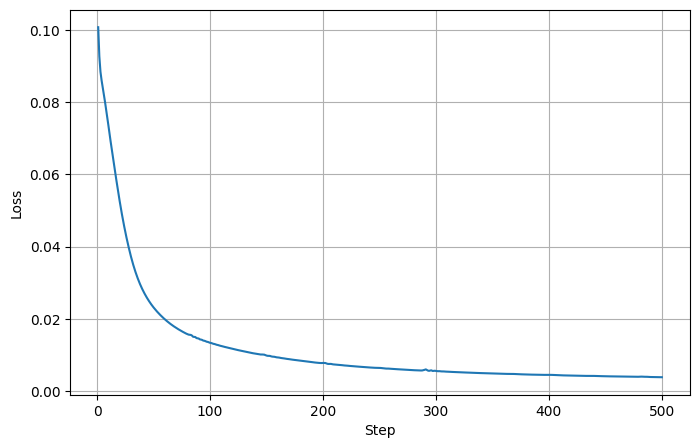

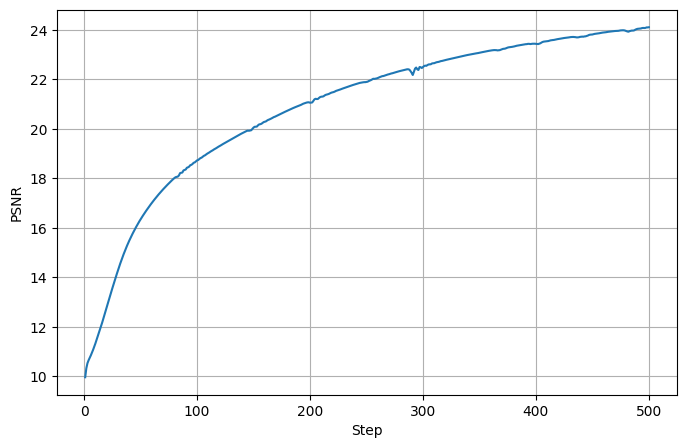

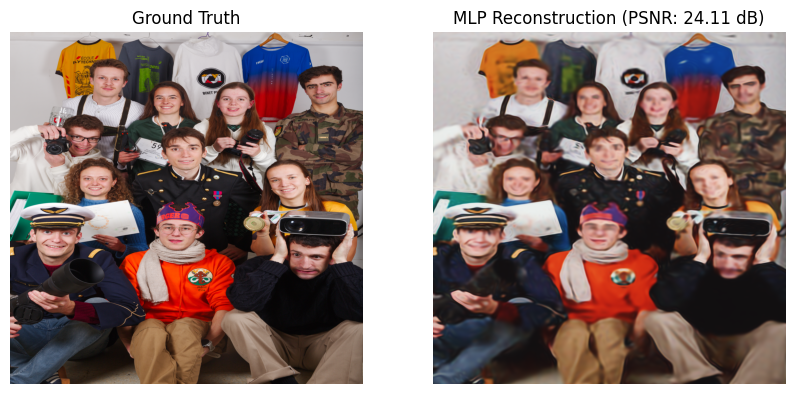

In [7]:
# [Bonus]

# try to use only partial data to train the SIREN or PE model
# sample only 10% to 30% of data and train the model

image_path = "Gabriel.Cheval.jpg"  # e.g., 'your_image.png' or None for synthetic
resolution = 2048 

if image_path is not None:
    img_np = load_image(image_path, resize=(resolution, resolution))
else:
    img_np = generate_synthetic_image(resolution)

coords, colors = prepare_dataset(img_np)
print(f"Dataset: {coords.shape[0]} samples, coordinate tensor shape {coords.shape}, color tensor shape {colors.shape}")


model = SIREN(in_dim = 2, hidden_dim=hidden_dim_siren, num_layers=num_layers_siren,
              out_dim=3, omega_0=omega_0)
model = model.to(device)

percentage = 0.30

total_pixels = coords.shape[0]
num_samples = int(total_pixels * percentage)

indices = torch.randperm(total_pixels)[:num_samples]

coords_subsampled = coords[indices]
colors_subsampled = colors[indices]

model_trained, history = train_model(model, coords_subsampled, colors_subsampled,num_iters=500, loss_type="mse", lr=1e-4)

plt.figure(figsize=(8, 5))
plt.plot(history["step"], history["loss"])
plt.xlabel('Step')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(history["step"], history["psnr"])
plt.xlabel('Step')
plt.ylabel('PSNR')
plt.grid(True)
plt.show()

# 1. Set model to evaluation mode (turns off dropout, etc.)
model_trained.eval()

# 2. Inference: Get the colors for all coordinates
with torch.no_grad():
    # Run the model on the full coordinate grid
    predicted_flat = model_trained(coords)
    
    # Move back to CPU and numpy for plotting
    # Reshape from (N, 3) -> (Height, Width, 3)
    # 'resolution' is 128 based on your earlier setup
    reconstructed_img = predicted_flat.reshape(resolution, resolution, 3).cpu().numpy()

# 3. Visualization
plt.figure(figsize=(10, 5))

# Plot Original (Ground Truth)
plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.title("Ground Truth")
plt.axis("off")

# Plot Reconstruction
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_img)
plt.title(f"MLP Reconstruction (PSNR: {history['psnr'][-1]:.2f} dB)")
plt.axis("off")

plt.show()